In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_cv

from tensorflow import keras


Using TensorFlow backend


In [11]:
BATCH_SIZE = 8

IMAGE_SIZE = (128, 128)

CLASSES = {
    0: "turtle",
    1: "penguin",
}

In [12]:
train_directory = "archive/train/train"
test_directory = "archive/valid/valid"

train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
print(train_paths)
test_paths =  sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))

['archive/train/train\\image_id_000.jpg', 'archive/train/train\\image_id_001.jpg', 'archive/train/train\\image_id_002.jpg', 'archive/train/train\\image_id_003.jpg', 'archive/train/train\\image_id_004.jpg', 'archive/train/train\\image_id_005.jpg', 'archive/train/train\\image_id_006.jpg', 'archive/train/train\\image_id_007.jpg', 'archive/train/train\\image_id_008.jpg', 'archive/train/train\\image_id_009.jpg', 'archive/train/train\\image_id_010.jpg', 'archive/train/train\\image_id_011.jpg', 'archive/train/train\\image_id_012.jpg', 'archive/train/train\\image_id_013.jpg', 'archive/train/train\\image_id_014.jpg', 'archive/train/train\\image_id_015.jpg', 'archive/train/train\\image_id_016.jpg', 'archive/train/train\\image_id_017.jpg', 'archive/train/train\\image_id_018.jpg', 'archive/train/train\\image_id_019.jpg', 'archive/train/train\\image_id_020.jpg', 'archive/train/train\\image_id_021.jpg', 'archive/train/train\\image_id_022.jpg', 'archive/train/train\\image_id_023.jpg', 'archive/train/

In [13]:
def preprocess_annotations(path):
    df = pd.read_json(path)
    df["category_id"] = df["category_id"].replace(2, 0)
    return df

train_annotations = preprocess_annotations('archive/train_annotations')
test_annotations = preprocess_annotations('archive/valid_annotations')

train_annotations.head()


id  image_id  category_id                  bbox    area segmentation  \
0   0         0            1   [119, 25, 205, 606]  124230           []   
1   1         1            1   [131, 82, 327, 440]  143880           []   
2   2         2            0  [225, 298, 198, 185]   36630           []   
3   3         3            0  [468, 109, 172, 193]   33196           []   
4   4         4            1   [14, 242, 611, 154]   94094           []   

   iscrowd  
0        0  
1        0  
2        0  
3        0  
4        0

In [14]:
resizer = keras_cv.layers.Resizing(
    *IMAGE_SIZE, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

augmenter = keras.Sequential(
    layers=[
        resizer,
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    ]
)

In [15]:
def get_image(path, label, bbox):
    file = tf.io.read_file(path)
    return tf.image.decode_jpeg(file), label, bbox

def to_dict(image, label, bbox):
    # Convert to object detection format expected by Keras CV
    bounding_boxes = {
        "classes": [label],
        "boxes": [bbox],
    }
    return {"images": image, "bounding_boxes": bounding_boxes}
def generate_dataset(image_paths, annotations, augment=False):
    return (
        tf.data.Dataset.from_tensor_slices((
            image_paths,
            annotations["category_id"],
            annotations["bbox"].to_list())
        )
        .map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(to_dict, num_parallel_calls=tf.data.AUTOTUNE)
        .ragged_batch(BATCH_SIZE)
        .map(lambda b: augmenter(b) if augment else resizer(b), num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )
    

train_dataset = generate_dataset(train_paths, train_annotations)
test_dataset = generate_dataset(test_paths, test_annotations)

# print(train_dataset)
# print(test_dataset)



<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>
<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>


In [16]:
from keras_cv.metrics import BoxCOCOMetrics
import tqdm
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )
    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            
            # Doesn't seem to work with ragged tensors :(
            y_pred = keras_cv.bounding_box.to_dense(y_pred, max_boxes=16)
            y_true = keras_cv.bounding_box.to_dense(y_true, max_boxes=16)

            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

In [17]:
from keras.optimizers import SGD

model = keras_cv.models.RetinaNet(
    num_classes=2,
    bounding_box_format="xywh",
    backbone=keras_cv.models.ResNet50Backbone.from_preset(
            "resnet50_imagenet"
    )
)
    
base_lr = 0.005
optimizer = SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
    
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
)

In [19]:
from keras_cv import bounding_box
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)


history = model.fit(
    train_ds,
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds)]
)


Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.2658 - box_loss: 0.6119 - classification_loss: 0.6539 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:08<00:00,  1.12it/s]

63/63 [==============================] - 77s 1s/step - loss: 1.2658 - box_loss: 0.6119 - classification_loss: 0.6539 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.1799 - MaP@[IoU=50]: 0.6349 - MaP@[IoU=75]: 0.0165 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1788 - MaP@[area=large]: 0.2000 - Recall@[max_detections=1]: 0.2735 - Recall@[max_detections=10]: 0.2735 - Recall@[max_detections=100]: 0.2735 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2806 - Recall@[area=large]: 0.2000


Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.8919 - box_loss: 0.4587 - classification_loss: 0.4332 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

63/63 [==============================] - 65s 1s/step - loss: 0.8919 - box_loss: 0.4587 - classification_loss: 0.4332 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.1211 - MaP@[IoU=50]: 0.4312 - MaP@[IoU=75]: 0.0023 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1227 - MaP@[area=large]: 0.1515 - Recall@[max_detections=1]: 0.1765 - Recall@[max_detections=10]: 0.2327 - Recall@[max_detections=100]: 0.2327 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2365 - Recall@[area=large]: 0.1500
Epoch 3/20


63/63 [==============================] - ETA: 0s - loss: 0.7209 - box_loss: 0.3542 - classification_loss: 0.3666 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

63/63 [==============================] - 65s 1s/step - loss: 0.7209 - box_loss: 0.3542 - classification_loss: 0.3666 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.1691 - MaP@[IoU=50]: 0.6247 - MaP@[IoU=75]: 0.0153 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1696 - MaP@[area=large]: 0.4020 - Recall@[max_detections=1]: 0.2537 - Recall@[max_detections=10]: 0.2740 - Recall@[max_detections=100]: 0.2740 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2759 - Recall@[area=large]: 0.4000


Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.5634 - box_loss: 0.2898 - classification_loss: 0.2737 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

63/63 [==============================] - 68s 1s/step - loss: 0.5634 - box_loss: 0.2898 - classification_loss: 0.2737 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.1396 - MaP@[IoU=50]: 0.5700 - MaP@[IoU=75]: 0.0319 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1397 - MaP@[area=large]: 0.2525 - Recall@[max_detections=1]: 0.2084 - Recall@[max_detections=10]: 0.2301 - Recall@[max_detections=100]: 0.2301 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2327 - Recall@[area=large]: 0.2500


Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 0.4594 - box_loss: 0.2441 - classification_loss: 0.2154 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

63/63 [==============================] - 67s 1s/step - loss: 0.4594 - box_loss: 0.2441 - classification_loss: 0.2154 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.2094 - MaP@[IoU=50]: 0.7395 - MaP@[IoU=75]: 0.0746 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2181 - MaP@[area=large]: 0.0505 - Recall@[max_detections=1]: 0.2887 - Recall@[max_detections=10]: 0.2928 - Recall@[max_detections=100]: 0.2928 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3058 - Recall@[area=large]: 0.0500
Epoch 6/20


63/63 [==============================] - ETA: 0s - loss: 0.3819 - box_loss: 0.2092 - classification_loss: 0.1727 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

63/63 [==============================] - 68s 1s/step - loss: 0.3819 - box_loss: 0.2092 - classification_loss: 0.1727 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.2136 - MaP@[IoU=50]: 0.7803 - MaP@[IoU=75]: 0.0436 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2225 - MaP@[area=large]: 0.1000 - Recall@[max_detections=1]: 0.3095 - Recall@[max_detections=10]: 0.3117 - Recall@[max_detections=100]: 0.3117 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3274 - Recall@[area=large]: 0.1000
Epoch 7/20


63/63 [==============================] - ETA: 0s - loss: 0.3605 - box_loss: 0.1943 - classification_loss: 0.1662 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

63/63 [==============================] - 70s 1s/step - loss: 0.3605 - box_loss: 0.1943 - classification_loss: 0.1662 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3095 - MaP@[IoU=50]: 0.8538 - MaP@[IoU=75]: 0.1316 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3245 - MaP@[area=large]: 0.1010 - Recall@[max_detections=1]: 0.4031 - Recall@[max_detections=10]: 0.4031 - Recall@[max_detections=100]: 0.4031 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4204 - Recall@[area=large]: 0.1000


Epoch 8/20
63/63 [==============================] - ETA: 0s - loss: 0.3274 - box_loss: 0.1750 - classification_loss: 0.1524 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.59it/s]

63/63 [==============================] - 69s 1s/step - loss: 0.3274 - box_loss: 0.1750 - classification_loss: 0.1524 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3020 - MaP@[IoU=50]: 0.9130 - MaP@[IoU=75]: 0.0908 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3265 - MaP@[area=large]: 0.1000 - Recall@[max_detections=1]: 0.3688 - Recall@[max_detections=10]: 0.3871 - Recall@[max_detections=100]: 0.3871 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4068 - Recall@[area=large]: 0.1000
Epoch 9/20


63/63 [==============================] - ETA: 0s - loss: 0.2831 - box_loss: 0.1531 - classification_loss: 0.1299 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:07<00:00,  1.28it/s]

63/63 [==============================] - 74s 1s/step - loss: 0.2831 - box_loss: 0.1531 - classification_loss: 0.1299 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.2458 - MaP@[IoU=50]: 0.8079 - MaP@[IoU=75]: 0.0971 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2513 - MaP@[area=large]: 0.1505 - Recall@[max_detections=1]: 0.3283 - Recall@[max_detections=10]: 0.3283 - Recall@[max_detections=100]: 0.3283 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3411 - Recall@[area=large]: 0.1500


Epoch 10/20
63/63 [==============================] - ETA: 0s - loss: 0.2371 - box_loss: 0.1381 - classification_loss: 0.0991 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

63/63 [==============================] - 70s 1s/step - loss: 0.2371 - box_loss: 0.1381 - classification_loss: 0.0991 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3811 - MaP@[IoU=50]: 0.8854 - MaP@[IoU=75]: 0.2118 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3855 - MaP@[area=large]: 0.3515 - Recall@[max_detections=1]: 0.4522 - Recall@[max_detections=10]: 0.4613 - Recall@[max_detections=100]: 0.4613 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4722 - Recall@[area=large]: 0.3500


Epoch 11/20
63/63 [==============================] - ETA: 0s - loss: 0.2262 - box_loss: 0.1343 - classification_loss: 0.0919 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

63/63 [==============================] - 67s 1s/step - loss: 0.2262 - box_loss: 0.1343 - classification_loss: 0.0919 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3896 - MaP@[IoU=50]: 0.9145 - MaP@[IoU=75]: 0.1840 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.4011 - MaP@[area=large]: 0.2505 - Recall@[max_detections=1]: 0.4590 - Recall@[max_detections=10]: 0.4590 - Recall@[max_detections=100]: 0.4590 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4739 - Recall@[area=large]: 0.2500


Epoch 12/20
63/63 [==============================] - ETA: 0s - loss: 0.1797 - box_loss: 0.1147 - classification_loss: 0.0650 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

63/63 [==============================] - 67s 1s/step - loss: 0.1797 - box_loss: 0.1147 - classification_loss: 0.0650 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3396 - MaP@[IoU=50]: 0.9065 - MaP@[IoU=75]: 0.1582 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3482 - MaP@[area=large]: 0.2505 - Recall@[max_detections=1]: 0.4266 - Recall@[max_detections=10]: 0.4281 - Recall@[max_detections=100]: 0.4281 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4411 - Recall@[area=large]: 0.2500
Epoch 13/20


63/63 [==============================] - ETA: 0s - loss: 0.1501 - box_loss: 0.0995 - classification_loss: 0.0506 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

63/63 [==============================] - 67s 1s/step - loss: 0.1501 - box_loss: 0.0995 - classification_loss: 0.0506 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3547 - MaP@[IoU=50]: 0.8654 - MaP@[IoU=75]: 0.2026 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3626 - MaP@[area=large]: 0.4515 - Recall@[max_detections=1]: 0.4154 - Recall@[max_detections=10]: 0.4184 - Recall@[max_detections=100]: 0.4184 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4298 - Recall@[area=large]: 0.4500


Epoch 14/20
63/63 [==============================] - ETA: 0s - loss: 0.1326 - box_loss: 0.0931 - classification_loss: 0.0395 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

63/63 [==============================] - 67s 1s/step - loss: 0.1326 - box_loss: 0.0931 - classification_loss: 0.0395 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3525 - MaP@[IoU=50]: 0.9385 - MaP@[IoU=75]: 0.1505 - MaP@[area=small]: 0.1000 - MaP@[area=medium]: 0.3537 - MaP@[area=large]: 0.4525 - Recall@[max_detections=1]: 0.4102 - Recall@[max_detections=10]: 0.4117 - Recall@[max_detections=100]: 0.4117 - Recall@[area=small]: 0.1000 - Recall@[area=medium]: 0.4146 - Recall@[area=large]: 0.4500
Epoch 15/20


63/63 [==============================] - ETA: 0s - loss: 0.1323 - box_loss: 0.0964 - classification_loss: 0.0359 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

63/63 [==============================] - 73s 1s/step - loss: 0.1323 - box_loss: 0.0964 - classification_loss: 0.0359 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.2618 - MaP@[IoU=50]: 0.8785 - MaP@[IoU=75]: 0.0713 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2657 - MaP@[area=large]: 0.4020 - Recall@[max_detections=1]: 0.3236 - Recall@[max_detections=10]: 0.3321 - Recall@[max_detections=100]: 0.3321 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3400 - Recall@[area=large]: 0.4000


Epoch 16/20
63/63 [==============================] - ETA: 0s - loss: 0.1305 - box_loss: 0.0972 - classification_loss: 0.0333 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

63/63 [==============================] - 73s 1s/step - loss: 0.1305 - box_loss: 0.0972 - classification_loss: 0.0333 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3366 - MaP@[IoU=50]: 0.8859 - MaP@[IoU=75]: 0.0968 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3389 - MaP@[area=large]: 0.5020 - Recall@[max_detections=1]: 0.3985 - Recall@[max_detections=10]: 0.4106 - Recall@[max_detections=100]: 0.4106 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4145 - Recall@[area=large]: 0.5000
Epoch 17/20


63/63 [==============================] - ETA: 0s - loss: 0.1026 - box_loss: 0.0737 - classification_loss: 0.0289 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

63/63 [==============================] - 70s 1s/step - loss: 0.1026 - box_loss: 0.0737 - classification_loss: 0.0289 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3822 - MaP@[IoU=50]: 0.9079 - MaP@[IoU=75]: 0.2153 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.3906 - MaP@[area=large]: 0.5020 - Recall@[max_detections=1]: 0.4645 - Recall@[max_detections=10]: 0.4645 - Recall@[max_detections=100]: 0.4645 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4771 - Recall@[area=large]: 0.5000


Epoch 18/20
63/63 [==============================] - ETA: 0s - loss: 0.0905 - box_loss: 0.0643 - classification_loss: 0.0263 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

63/63 [==============================] - 71s 1s/step - loss: 0.0905 - box_loss: 0.0643 - classification_loss: 0.0263 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3983 - MaP@[IoU=50]: 0.9613 - MaP@[IoU=75]: 0.2056 - MaP@[area=small]: 0.0505 - MaP@[area=medium]: 0.4081 - MaP@[area=large]: 0.4515 - Recall@[max_detections=1]: 0.4785 - Recall@[max_detections=10]: 0.4785 - Recall@[max_detections=100]: 0.4785 - Recall@[area=small]: 0.0500 - Recall@[area=medium]: 0.4928 - Recall@[area=large]: 0.4500
Epoch 19/20


63/63 [==============================] - ETA: 0s - loss: 0.0902 - box_loss: 0.0650 - classification_loss: 0.0252 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.50it/s]

63/63 [==============================] - 71s 1s/step - loss: 0.0902 - box_loss: 0.0650 - classification_loss: 0.0252 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3880 - MaP@[IoU=50]: 0.9037 - MaP@[IoU=75]: 0.2078 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.4006 - MaP@[area=large]: 0.4020 - Recall@[max_detections=1]: 0.4528 - Recall@[max_detections=10]: 0.4528 - Recall@[max_detections=100]: 0.4528 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4688 - Recall@[area=large]: 0.4000


Epoch 20/20
63/63 [==============================] - ETA: 0s - loss: 0.0994 - box_loss: 0.0748 - classification_loss: 0.0246 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.53it/s]

63/63 [==============================] - 72s 1s/step - loss: 0.0994 - box_loss: 0.0748 - classification_loss: 0.0246 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.3499 - MaP@[IoU=50]: 0.8883 - MaP@[IoU=75]: 0.1300 - MaP@[area=small]: 0.0505 - MaP@[area=medium]: 0.3577 - MaP@[area=large]: 0.4525 - Recall@[max_detections=1]: 0.4245 - Recall@[max_detections=10]: 0.4259 - Recall@[max_detections=100]: 0.4259 - Recall@[area=small]: 0.0500 - Recall@[area=medium]: 0.4361 - Recall@[area=large]: 0.4500


(640, 640, 3)
1/1 [==============================] - 0s 158ms/step
0
[[[26.432518 45.818623 87.94083  71.7388  ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1.       -1.       -1.       -1.      ]
  [-1. 

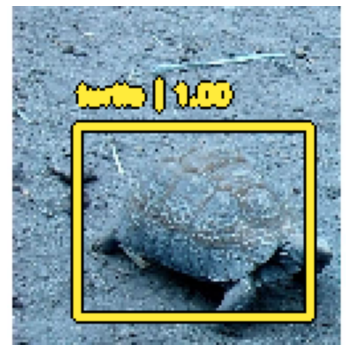

In [90]:
from keras_cv import visualization
import cv2


inference_resizing = keras_cv.layers.Resizing(
    128, 128, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
img = cv2.imread('archive/train/train/image_id_035.jpg')
print(img.shape)
img = [img]
img = np.array(img)
img = inference_resizing(img)
# loaded_model.predict(img)
prediction = model.predict(img)
# img -= np.mean(img,axis=0)
# p = loaded_model.predict(x)


# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
# print(prediction)
# print(prediction['boxes'][0])
classes = prediction['classes'][0][0]
boxes = prediction['boxes']
print(classes)
print(boxes)
visualization.plot_bounding_box_gallery(
    img,
    value_range=(0, 255),
    scale = 5,
    cols=1,
    rows=1,
    font_scale=0.3,
    y_pred=prediction,
    # y_true=batch["bounding_boxes"],
    bounding_box_format="xywh",
    class_mapping=CLASSES,
)

